### Continent specific crown area allometries 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

import modp as mp

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_trop = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')
df_trop = df_trop.dropna(subset=['crown_area','dbh'])
df_trop_orig = df_trop

### Crown area allometry

In [3]:
def d2ca (d, p1, p2) :
    ca = p1 * d ** p2
    return ca

initial_guess = [0.7, 1.3]    

In [4]:
def fit_d2ca (df, initial_guess) :
    # remove nas  in dbh and CA
    df = df.dropna(subset=['crown_area','dbh'])
    # remove outliers
    df  = df[df['crown_radius_outlier']=='N']
   
    ca_ps, ca_cov = curve_fit(f=d2ca, xdata=np.array(df['dbh']), ydata=np.array(df['crown_area']),
                                           p0=initial_guess)

    return ca_ps #, ca_cov

### Filter by three realms 

In [5]:
df_trop = df_trop.loc[df_trop['realm'].isin(['Afrotropic','Indo-Malaya','Neotropic'])]

In [6]:
df_trop = df_trop.drop(df_trop[(df_trop.dbh < 50) & (df_trop.crown_area > 500) & (df_trop.realm == 'Indo-Malaya')].index)

In [7]:
realms = df_trop['realm'].unique()
print(realms)

['Indo-Malaya' 'Neotropic' 'Afrotropic']


In [8]:
ca_ps = [fit_d2ca(d[1], initial_guess) for d in df_trop.groupby('realm')]

ca_ps

[array([0.73430734, 1.29037016]),
 array([0.10532798, 1.63473029]),
 array([0.24736252, 1.50008387])]

Text(0.02, 0.5, 'Crown area (m2)')

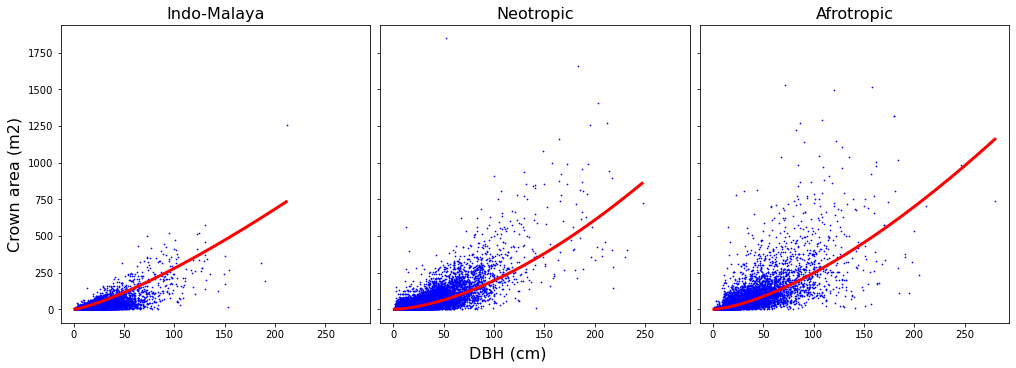

In [9]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,5), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,len(realms)): 
    realm = realms[i]
    ps = ca_ps[i]
    df = df_trop.loc[df_trop['realm'] == realm]
    df  = df[df['crown_radius_outlier']=='N']
    dbh = np.arange(1, df['dbh'].max(),1)
    curve = [d2ca(d, ps[0], ps[1])  for  d  in dbh]

    axs[i].scatter(df['dbh'], df['crown_area'], s=0.5, color='blue')
    axs[i].plot(dbh, curve, color='red', linewidth=3.0)
    axs[i].set_title(realm,  fontsize=16)
 
fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)

### Filter  by biome 

In [10]:
df_rf = df_trop.loc[df_trop['biome'] == 'Tropical rain forest']
realms_rf = df_rf.realm.unique()
df_df = df_trop.loc[df_trop['biome'] == 'Tropical dry forest']
realms_df = df_df.realm.unique()
df_s = df_trop.loc[df_trop['biome'] == 'Tropical savanna']
realms_s = df_s.realm.unique()

In [11]:
df_s.groupby('realm').size()

realm
Afrotropic    5275
Neotropic      179
dtype: int64

In [12]:
df_rf.groupby('realm').size()

realm
Afrotropic      5597
Indo-Malaya    37328
Neotropic      17227
dtype: int64

In [13]:
ca_ps_rf = [fit_d2ca(d[1], initial_guess) for d in df_rf.groupby('realm')]
ca_ps_df = [fit_d2ca(d[1], initial_guess) for d in df_df.groupby('realm')]
ca_ps_s = [fit_d2ca(d[1], initial_guess) for d in df_s.groupby('realm')]

1
2


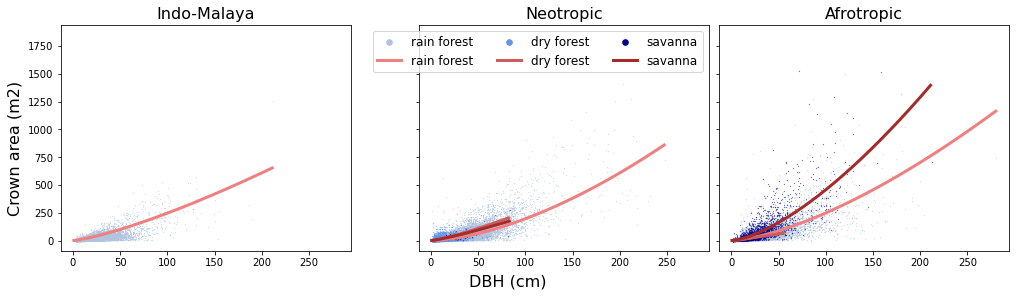

In [14]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,len(realms_rf)): 
    realm = realms_rf[i]
    ps_rf = ca_ps_rf[i]
    tmp = df_rf.loc[df_rf['realm'] == realm]
    dbh_rf = np.arange(1, tmp['dbh'].max(),1)
    curve_rf = [d2ca(d, ps_rf[0], ps_rf[1])  for  d  in dbh_rf]
    axs[i].scatter(tmp['dbh'], tmp['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
    axs[i].plot(dbh_rf, curve_rf, color='lightcoral',label='rain forest',linewidth=3.0)
    axs[i].set_title(realm,  fontsize=16)

for i in np.arange(0,len(realms_df)): 
    realm = realms_df[i]
    ps_df = ca_ps_df[i]
    tmp = df_df.loc[df_df['realm'] == realm]
    dbh_df = np.arange(1, tmp['dbh'].max(),1)
    curve_df = [d2ca(d, ps_df[0], ps_df[1])  for  d  in dbh_df]
    axsi = np.where(realms_rf == realm)[0][0]
    print(axsi)
    axs[axsi].scatter(tmp['dbh'], tmp['crown_area'], s=0.05, color='cornflowerblue', label = 'dry forest')
    axs[axsi].plot(dbh_df, curve_df, color='indianred', label = 'dry forest', linewidth=3.0)

for i in np.arange(0,len(realms_s)): 
    realm = realms_s[i]
    ps_s = ca_ps_s[i]
    tmp = df_s.loc[df_s['realm'] == realm] 
    dbh_s = np.arange(1, tmp['dbh'].max(),1)
    curve_s = [d2ca(d, ps_s[0], ps_s[1])  for  d  in dbh_s]
    axsi =  np.where(realms_rf == realm)[0][0]
    axs[axsi].scatter(tmp['dbh'], tmp['crown_area'], s=0.05, color='darkblue', label = 'savanna')
    axs[axsi].plot(dbh_s, curve_s, color='brown', label = 'savanna', linewidth=3.0)
   

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)

axs[1].legend(fontsize=12, ncol=3, markerscale=25)

## Final parameters

- Indo-Malaya - dipterocarps for everggreen PFT and dry forests hydro-deciduous PFT
- Neo-tropics - all rain forest species for evergreen PFT, and dry forest for hydro-deciduous PFT
- Afrotropics - all rain forest species for evergreen PFT and savanna for hydro-deciduous PFT

In [15]:
initial_guess = [0.7, 1.3]    
ds = np.arange(1, 250, 1)

### Asia

#### Evergreen - Dipterocarpaceae

In [16]:
df_rf_asia = df_rf.loc[df_rf['realm'] == 'Indo-Malaya']
df_rf_asia = df_rf_asia.loc[df_rf_asia['family'] == 'Dipterocarpaceae']
rf_asia_ps = fit_d2ca(df_rf_asia, initial_guess)
curve_rf_asia = [d2ca(d, rf_asia_ps[0], rf_asia_ps[1])  for  d  in ds]

### Americas

#### Evergreen - rain forests

In [17]:
df_rf_americas = df_rf.loc[df_rf['realm'] == 'Neotropic']
rf_americas_ps = fit_d2ca(df_rf_americas, initial_guess)
curve_rf_americas = [d2ca(d, rf_americas_ps[0], rf_americas_ps[1])  for  d  in ds]

#### Hydro-deciduous - dry forests

In [18]:
df_df_americas = df_df.loc[df_df['realm'] == 'Neotropic']
df_americas_ps = fit_d2ca(df_df_americas, initial_guess)
curve_df_americas = [d2ca(d, df_americas_ps[0], df_americas_ps[1])  for  d  in ds]

### Africa

#### Evergreen - rain forest

In [19]:
df_rf_africa = df_rf.loc[df_rf['realm'] == 'Afrotropic']
rf_africa_ps = fit_d2ca(df_rf_africa, initial_guess)
curve_rf_africa = [d2ca(d, rf_africa_ps[0], rf_africa_ps[1])  for  d  in ds]

#### Hydro-deciduos - savanna

In [20]:
df_s_africa = df_s.loc[df_s['realm'] == 'Afrotropic']
s_africa_ps = fit_d2ca(df_s_africa, initial_guess)
curve_s_africa = [d2ca(d, s_africa_ps[0], s_africa_ps[1])  for  d  in ds]

Text(0.02, 0.5, 'Crown area (m2)')

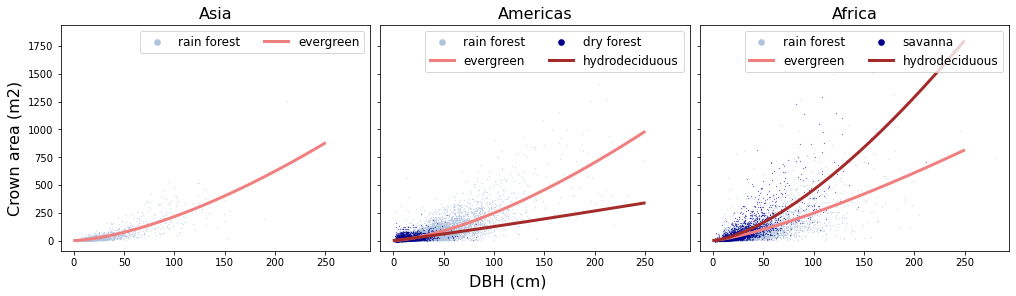

In [21]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(df_rf_asia['dbh'], df_rf_asia['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(df_rf_americas['dbh'], df_rf_americas['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_df_americas['dbh'], df_df_americas['crown_area'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)

axs[2].scatter(df_rf_africa['dbh'], df_rf_africa['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(df_s_africa['dbh'], df_s_africa['crown_area'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)



### Add in the current allometry

In [22]:
global_ca = [d2ca(d, 0.2715891, 1.6019679)  for  d  in ds]

Text(0.02, 0.5, 'Crown area (m2)')

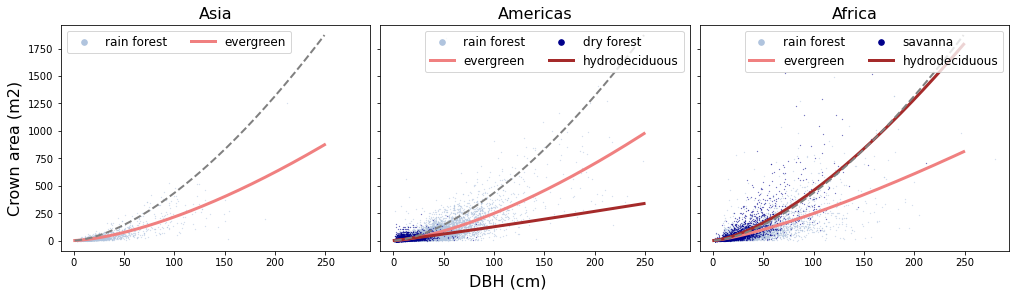

In [23]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(df_rf_asia['dbh'], df_rf_asia['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)
axs[0].plot(ds, global_ca, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


axs[1].scatter(df_rf_americas['dbh'], df_rf_americas['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_df_americas['dbh'], df_df_americas['crown_area'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)
axs[1].plot(ds, global_ca, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


axs[2].scatter(df_rf_africa['dbh'], df_rf_africa['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(df_s_africa['dbh'], df_s_africa['crown_area'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)
axs[2].plot(ds, global_ca, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)

### Modify the parameter file

In [24]:
# final parameter file name
fout = '/global/homes/j/jneedham/tropical-fixed-biog/param_files/fates_params_tropical_allom.nc'
organ = 1

# American evergreen
pft = 1
var = 'fates_allom_d2ca_coefficient_max'
val = rf_americas_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2ca_coefficient_min'
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2bl2'
val = rf_americas_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var =  'fates_allom_blca_expnt_diff'
val = 0
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)

# American hydro-deciduous
pft = 4
var = 'fates_allom_d2ca_coefficient_max'
val = df_americas_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2ca_coefficient_min'
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2bl2'
val = df_americas_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var =  'fates_allom_blca_expnt_diff'
val = 0
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)


# African evergreen
pft = 2
var = 'fates_allom_d2ca_coefficient_max'
val = rf_africa_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2ca_coefficient_min'
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2bl2'
val = rf_africa_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var =  'fates_allom_blca_expnt_diff'
val = 0
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)

# African hydro-deciduous
pft = 5
var = 'fates_allom_d2ca_coefficient_max'
val = s_africa_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2ca_coefficient_min'
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2bl2'
val = s_africa_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var =  'fates_allom_blca_expnt_diff'
val = 0
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)


# Asian evergreen
pft = 3
var = 'fates_allom_d2ca_coefficient_max'
val = rf_asia_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2ca_coefficient_min'
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2bl2'
val = rf_asia_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var =  'fates_allom_blca_expnt_diff'
val = 0
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)

# Asian hydro-deciduous
pft = 6
var = 'fates_allom_d2ca_coefficient_max'
val = rf_asia_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2ca_coefficient_min'
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2bl2'
val = rf_asia_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var =  'fates_allom_blca_expnt_diff'
val = 0
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)








## Pantropical allometry 

In [25]:
df_trop = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')
df_trop = df_trop.dropna(subset=['crown_area','dbh'])
df_trop_orig = df_trop

In [26]:
df_trop = df_trop.loc[df_trop['realm'].isin(['Afrotropic','Indo-Malaya','Neotropic'])]

In [27]:
df_trop = df_trop.drop(df_trop[(df_trop.dbh < 50) & (df_trop.crown_area > 500) & (df_trop.realm == 'Indo-Malaya')].index)

### Filter  by biome 

In [28]:
df_rf = df_trop.loc[df_trop['biome'] == 'Tropical rain forest']
realms_rf = df_rf.realm.unique()

df_df = df_trop.loc[df_trop['biome'] == 'Tropical dry forest']
realms_df = df_df.realm.unique()

df_s = df_trop.loc[df_trop['biome'] == 'Tropical savanna']
realms_s = df_s.realm.unique()

df_dfs = df_trop.loc[df_trop['biome'].isin(['Tropical dry forest','Tropical savanna'])]

In [29]:
ca_ps_rf = fit_d2ca(df_rf, initial_guess) 
ca_ps_df = fit_d2ca(df_df, initial_guess)
ca_ps_s = fit_d2ca(df_s, initial_guess)

ca_ps_dfs = fit_d2ca(df_dfs,  initial_guess)

In [30]:
print(ca_ps_rf)
print(ca_ps_dfs)

[0.22267948 1.51492794]
[0.28895957 1.59335073]


In [43]:
curve_rf = [d2ca(d, ca_ps_rf[0], ca_ps_rf[1])  for  d  in ds]
curve_df = [d2ca(d, ca_ps_df[0], ca_ps_df[1])  for  d  in ds]
curve_s = [d2ca(d, ca_ps_s[0], ca_ps_s[1])  for  d  in ds]
curve_dfs = [d2ca(d, ca_ps_dfs[0], ca_ps_dfs[1])  for d in ds]

#### Separate dry forest and savanna

Text(0.02, 0.5, 'Crown area (m2)')

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


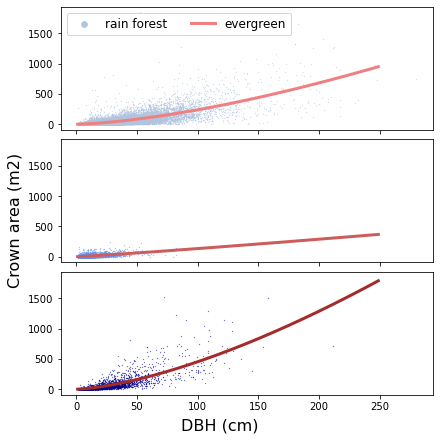

In [48]:
fig1, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)

axs = axs.flatten()

axs[0].scatter(df_rf['dbh'], df_rf['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)

axs[1].scatter(df_df['dbh'], df_df['crown_area'], s=0.05, color='cornflowerblue', label = 'dry forest')
axs[1].plot(ds, curve_df, color='indianred',label='deciduous',linewidth=3.0)

axs[2].scatter(df_s['dbh'], df_s['crown_area'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s, color='brown',label='savanna',linewidth=3.0)


axs[0].legend(fontsize=12, ncol=3, markerscale=25)
axs[1].legend(fontsize=12, ncol=3, markerscale=25)
axs[2].legend(fontsize=12, ncol=3, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)



#### Just evergreen v deciduous

Text(0.02, 0.5, 'Crown area (m2)')

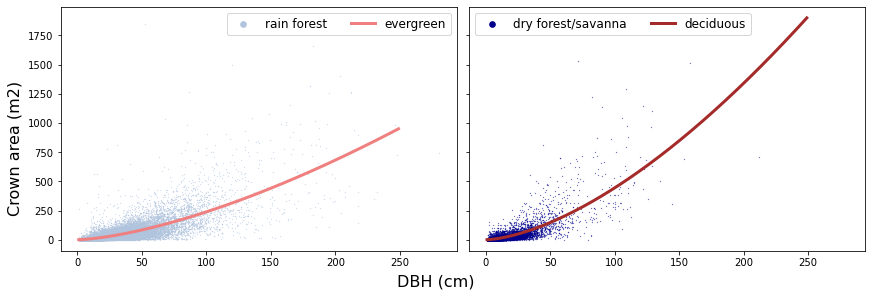

In [50]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=True, sharey=True, constrained_layout=True)

axs = axs.flatten()

axs[0].scatter(df_rf['dbh'], df_rf['crown_area'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)

axs[1].scatter(df_dfs['dbh'], df_dfs['crown_area'], s=0.05, color='darkblue', label = 'dry forest/savanna')
axs[1].plot(ds, curve_dfs, color='brown',label='deciduous',linewidth=3.0)

axs[0].legend(fontsize=12, ncol=3, markerscale=25)
axs[1].legend(fontsize=12, ncol=3, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Crown area (m2)', fontsize=16)